In [1]:
import numpy as np
import pandas as pd
import optuna
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.losses import MeanSquaredError
from keras.optimizers import Adam, RMSprop

In [2]:
dataset = pd.read_csv('../dataset/dados_pregao_tots3.csv')
colunas = ['data_pregao', 'preco_ultimo_negocio']
data = dataset[colunas].copy()

data.loc[:, 'data_pregao'] = pd.to_datetime(data['data_pregao'])

data.set_index('data_pregao', inplace=True)

test_data = None
train_data = None
train_data_values = None
test_data_values = None

test_data = data.tail(30)
train_data = data.iloc[:-30]

train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values

data

,preco_ultimo_negocio
data_pregao,
2018-01-02,30.15
2018-01-03,30.79
2018-01-04,30.60
2018-01-05,31.26
2018-01-08,31.24
...,...
2024-10-01,28.66
2024-10-02,29.45
2024-10-03,28.12


30 DIAS

In [3]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [4]:
def objective(trial):
    units = trial.suggest_int('units', 32, 128)  
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units, activation='relu'))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=MeanSquaredError())

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    val_loss = model.evaluate(X_test, y_test, verbose=0)
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print(f"Melhores Hiperparâmetros: {best_params}")

best_model = Sequential()
best_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(LSTM(best_params['units'], activation='relu'))
best_model.add(Dense(1))

if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])

best_model.compile(optimizer=optimizer, loss=MeanSquaredError())

best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

predictions = best_model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

[I 2024-10-21 19:52:49,161] A new study created in memory with name: no-name-599f8081-5695-4d5d-9333-67bb4767afd8
[I 2024-10-21 19:53:50,341] Trial 0 finished with value: 2.525326728820801 and parameters: {'units': 52, 'learning_rate': 0.004344939771766397, 'optimizer': 'adam'}. Best is trial 0 with value: 2.525326728820801.
[I 2024-10-21 19:54:38,259] Trial 1 finished with value: 7.028595924377441 and parameters: {'units': 42, 'learning_rate': 0.0014188308733158164, 'optimizer': 'adam'}. Best is trial 0 with value: 2.525326728820801.
[I 2024-10-21 19:56:00,503] Trial 2 finished with value: 1.8128767013549805 and parameters: {'units': 97, 'learning_rate': 2.6717522869181527e-05, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 1.8128767013549805.
[I 2024-10-21 19:56:48,760] Trial 3 finished with value: 9.6195068359375 and parameters: {'units': 41, 'learning_rate': 2.5290614736306096e-05, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 1.8128767013549805.
[I 2024-10-21 19:57:57

Melhores Hiperparâmetros: {'units': 97, 'learning_rate': 2.6717522869181527e-05, 'optimizer': 'rmsprop'}
Test Loss: 2.2390286922454834
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Squared Error (MSE): 250.57749844411174
Root Mean Squared Error (RMSE): 15.829639870954479
Mean Absolute Percentage Error (MAPE): 28.574572417476276%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Mean Squared Error (MSE): 0.5789306728808413
Root Mean Squared Error (RMSE): 0.7608749390542715
Mean Absolute Percentage Error (MAPE): 2.062403075653527%


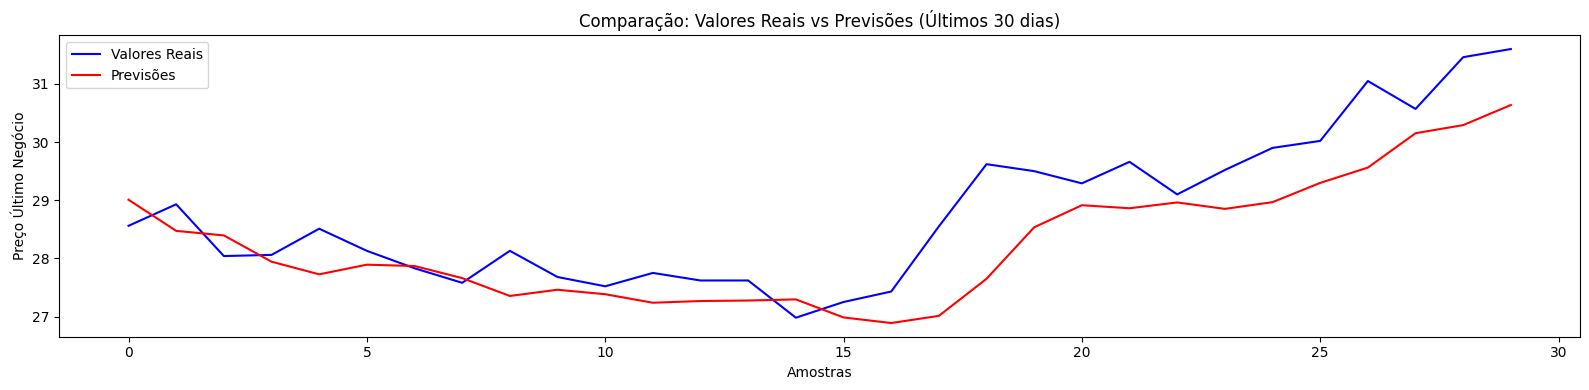

In [5]:
comparison_data = train_data.iloc[-60:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

predictions = best_model.predict(X_test_sequences)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 30 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

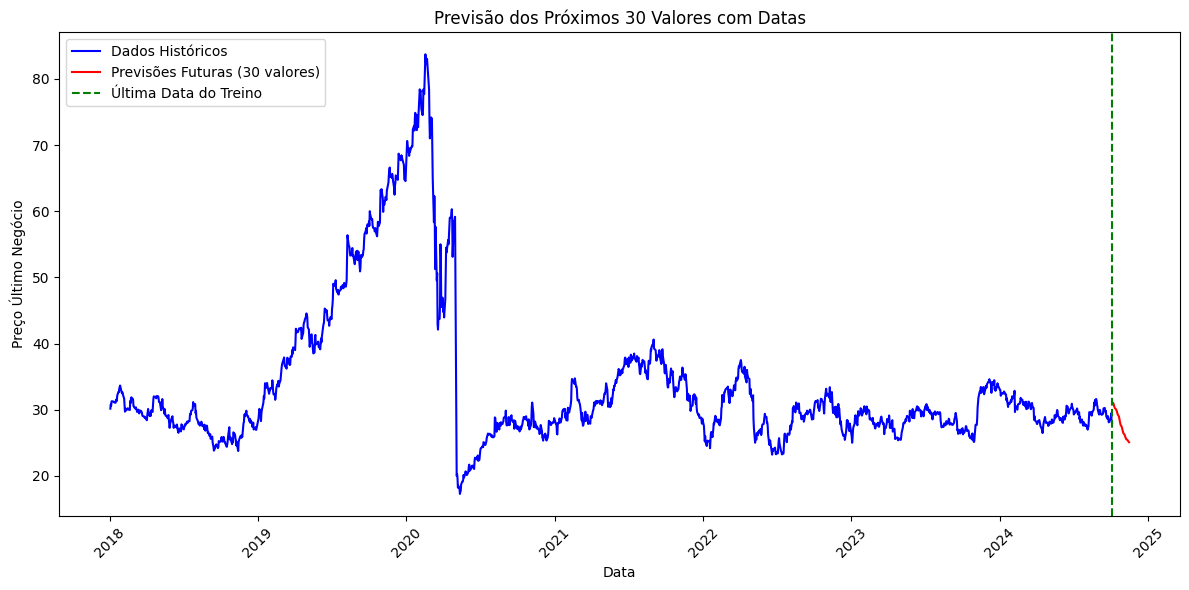

In [6]:
last_sequence = train_data_values[-sequence_length:]
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(30):
    next_prediction = best_model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

future_predictions = np.array(future_predictions).flatten()

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (30 valores)', color='red')
plt.title('Previsão dos Próximos 30 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

60 DIAS

In [7]:
test_data = None
train_data = None
train_data_values = None
test_data_values = None

test_data = data.tail(60)
train_data = data.iloc[:-60]

train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values

In [8]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [9]:
def objective(trial):
    units = trial.suggest_int('units', 32, 128)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units, activation='relu'))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=MeanSquaredError())

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    val_loss = model.evaluate(X_test, y_test, verbose=0)
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Número de tentativas

best_params = study.best_params
print(f"Melhores Hiperparâmetros: {best_params}")

best_model = Sequential()
best_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(LSTM(best_params['units'], activation='relu'))
best_model.add(Dense(1))

if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])

best_model.compile(optimizer=optimizer, loss=MeanSquaredError())

best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

predictions = best_model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

[I 2024-10-21 20:04:10,614] A new study created in memory with name: no-name-39ecd158-2fa1-4338-a658-47a8ad1984c0
[I 2024-10-21 20:05:22,346] Trial 0 finished with value: 6.285282135009766 and parameters: {'units': 85, 'learning_rate': 1.5826203720541417e-05, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 6.285282135009766.
[I 2024-10-21 20:07:04,757] Trial 1 finished with value: 80.18085479736328 and parameters: {'units': 125, 'learning_rate': 0.007569257475716284, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 6.285282135009766.
[I 2024-10-21 20:08:27,222] Trial 2 finished with value: 2.021134853363037 and parameters: {'units': 103, 'learning_rate': 0.00014197375265770818, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 2.021134853363037.
[I 2024-10-21 20:09:24,457] Trial 3 finished with value: 1.9257079362869263 and parameters: {'units': 70, 'learning_rate': 0.0024959430942397024, 'optimizer': 'adam'}. Best is trial 3 with value: 1.9257079362869263.
[I 2024-10-21 20

Melhores Hiperparâmetros: {'units': 79, 'learning_rate': 0.0002145739668736134, 'optimizer': 'adam'}
Test Loss: 4.970026969909668
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean Squared Error (MSE): 246.60958134030378
Root Mean Squared Error (RMSE): 15.70380786116233
Mean Absolute Percentage Error (MAPE): 27.961914552588713%


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Squared Error (MSE): 1.0519968331407046
Root Mean Squared Error (RMSE): 1.0256689685959621
Mean Absolute Percentage Error (MAPE): 2.7851223030896377%


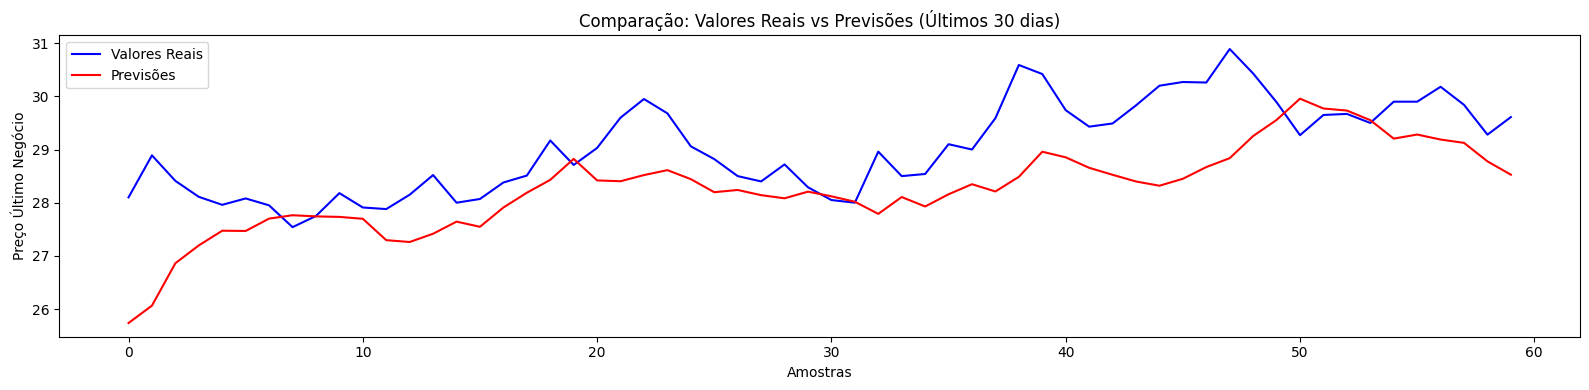

In [10]:
comparison_data = train_data.iloc[-90:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

predictions = best_model.predict(X_test_sequences)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 30 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

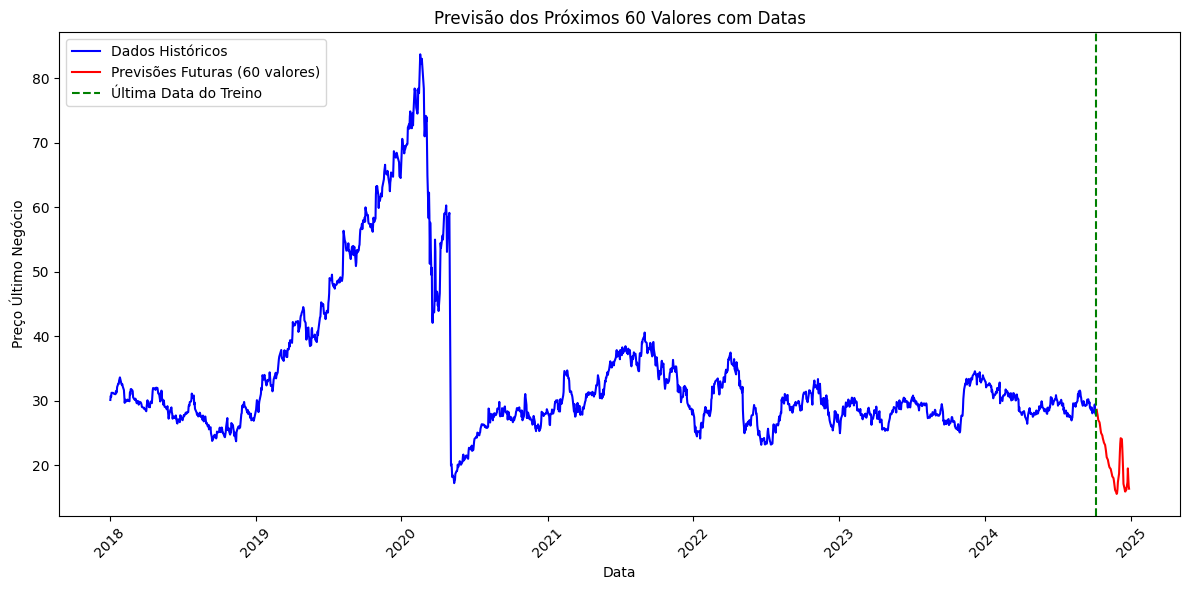

In [11]:
last_sequence = train_data_values[-sequence_length:]
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(60):
    next_prediction = best_model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

future_predictions = np.array(future_predictions).flatten()

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='B')

future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (60 valores)', color='red')
plt.title('Previsão dos Próximos 60 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

90 DIAS

In [12]:
test_data = None
train_data = None
train_data_values = None
test_data_values = None

test_data = data.tail(90)
train_data = data.iloc[:-90]

train_data_values = train_data['preco_ultimo_negocio'].values
test_data_values = test_data['preco_ultimo_negocio'].values

In [13]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data_values, sequence_length)
X_test, y_test = create_sequences(train_data_values, sequence_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  

In [14]:
def objective(trial):
    units = trial.suggest_int('units', 32, 128) 
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])

    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units, activation='relu'))
    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss=MeanSquaredError())

    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    val_loss = model.evaluate(X_test, y_test, verbose=0)
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10) 

best_params = study.best_params
print(f"Melhores Hiperparâmetros: {best_params}")

best_model = Sequential()
best_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(LSTM(best_params['units'], activation='relu'))
best_model.add(Dense(1))

if best_params['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_params['learning_rate'])
else:
    optimizer = RMSprop(learning_rate=best_params['learning_rate'])

best_model.compile(optimizer=optimizer, loss=MeanSquaredError())

best_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

test_loss = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

predictions = best_model.predict(X_test)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

[I 2024-10-21 20:16:08,840] A new study created in memory with name: no-name-2fd4b110-641a-4806-aa69-274f8313831f
[I 2024-10-21 20:17:40,935] Trial 0 finished with value: 2.7879700660705566 and parameters: {'units': 115, 'learning_rate': 0.0012894569832723544, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 2.7879700660705566.
[I 2024-10-21 20:18:56,854] Trial 1 finished with value: 5.301037788391113 and parameters: {'units': 112, 'learning_rate': 2.703142734910422e-05, 'optimizer': 'rmsprop'}. Best is trial 0 with value: 2.7879700660705566.
[I 2024-10-21 20:20:18,734] Trial 2 finished with value: 2.740673542022705 and parameters: {'units': 101, 'learning_rate': 0.0016236221919345933, 'optimizer': 'adam'}. Best is trial 2 with value: 2.740673542022705.
[I 2024-10-21 20:21:48,313] Trial 3 finished with value: 2.9690101146698 and parameters: {'units': 111, 'learning_rate': 0.0024555685148605557, 'optimizer': 'rmsprop'}. Best is trial 2 with value: 2.740673542022705.
[I 2024-10-21 20

Melhores Hiperparâmetros: {'units': 60, 'learning_rate': 0.00021880467753665388, 'optimizer': 'rmsprop'}
Test Loss: 1.7237273454666138
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Mean Squared Error (MSE): 263.88697814631024
Root Mean Squared Error (RMSE): 16.24459842982615
Mean Absolute Percentage Error (MAPE): 29.99707521090719%


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Squared Error (MSE): 0.34372582721406975
Root Mean Squared Error (RMSE): 0.5862813549944
Mean Absolute Percentage Error (MAPE): 1.4235649788820668%


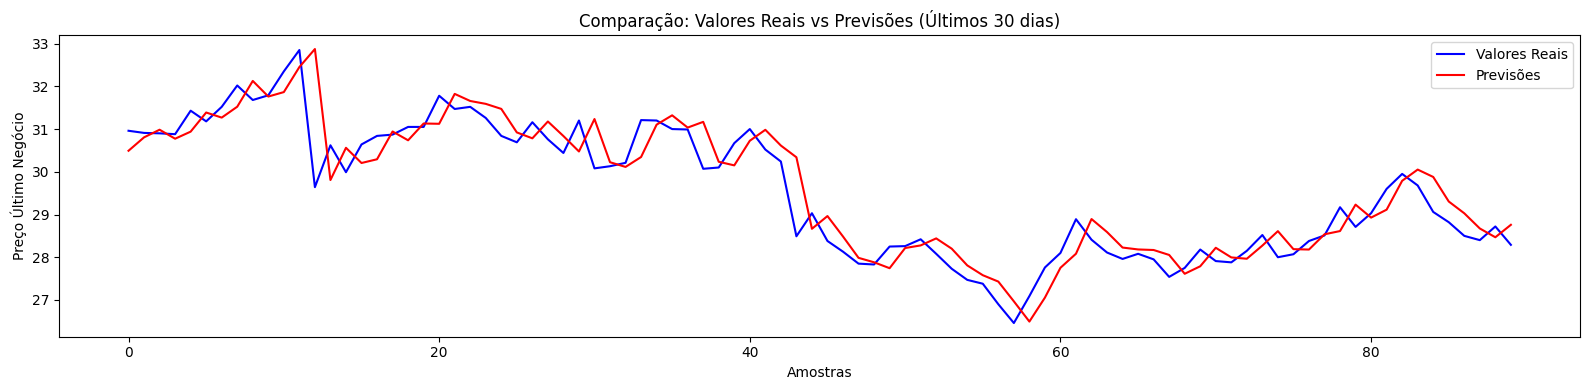

In [15]:
comparison_data = train_data.iloc[-120:]
X_test = comparison_data['preco_ultimo_negocio'].values.reshape(-1, 1)

X_test_sequences = []
y_test = []

for i in range(len(X_test) - sequence_length):
    X_test_sequences.append(X_test[i:i + sequence_length])
    y_test.append(X_test[i + sequence_length])

X_test_sequences = np.array(X_test_sequences)
y_test = np.array(y_test)

X_test_sequences = X_test_sequences.reshape((X_test_sequences.shape[0], sequence_length, 1))

predictions = best_model.predict(X_test_sequences)

mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)

non_zero_indices = y_test != 0
mape = np.mean(np.abs((y_test[non_zero_indices] - predictions[non_zero_indices]) / y_test[non_zero_indices])) * 100

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

results_df = pd.DataFrame({
    'Real': y_test.flatten(),
    'Previsão': predictions.flatten()
})

plt.figure(figsize=(16, 4))
plt.plot(results_df['Real'], label='Valores Reais', color='blue')
plt.plot(results_df['Previsão'], label='Previsões', color='red')

plt.title('Comparação: Valores Reais vs Previsões (Últimos 30 dias)')
plt.xlabel('Amostras')
plt.ylabel('Preço Último Negócio')
plt.legend()
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

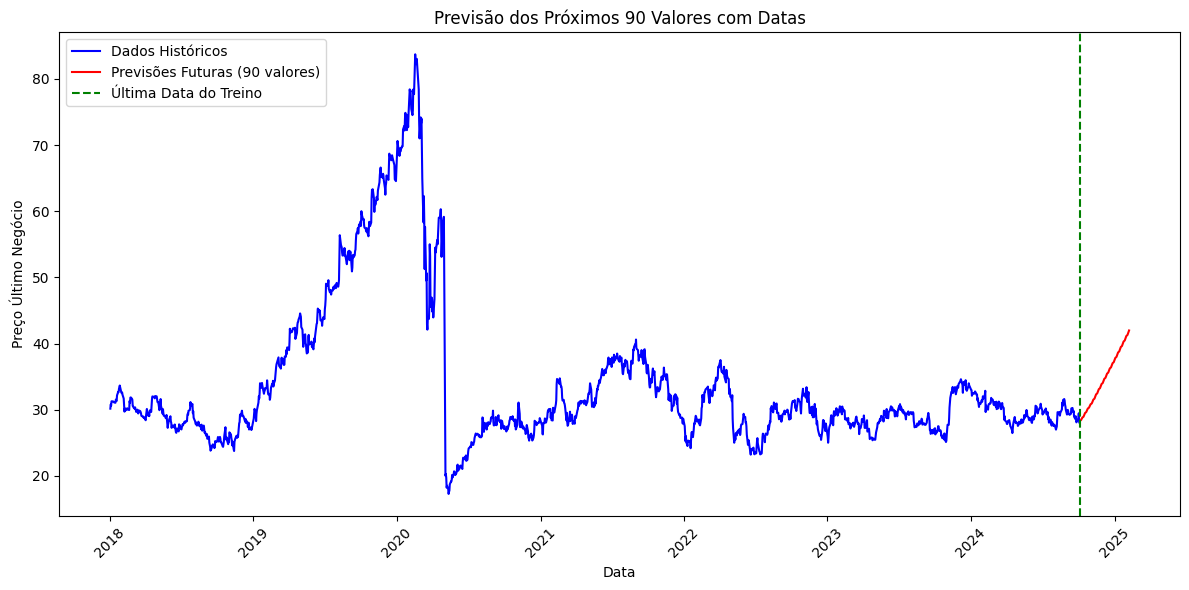

In [16]:
last_sequence = train_data_values[-sequence_length:]
future_predictions = []

current_sequence = last_sequence.reshape((1, sequence_length, 1))

for _ in range(90):
    next_prediction = best_model.predict(current_sequence)[0]
    future_predictions.append(next_prediction)

    current_sequence = np.append(current_sequence[:, 1:, :], [[next_prediction]], axis=1)

future_predictions = np.array(future_predictions).flatten()

last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=90, freq='B')

future_df = pd.DataFrame({'Date': future_dates, 'LSTM Prediction': future_predictions})

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['preco_ultimo_negocio'], label='Dados Históricos', color='blue')
plt.plot(future_df['Date'], future_df['LSTM Prediction'], label='Previsões Futuras (90 valores)', color='red')
plt.title('Previsão dos Próximos 90 Valores com Datas')
plt.xlabel('Data')
plt.ylabel('Preço Último Negócio')
plt.axvline(x=last_date, color='green', linestyle='--', label='Última Data do Treino')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()